# IPCV Project Work - Testing `LightGlue`: *Local Feature Matching at Light Speed*

From [ICCV 2023](https://iccv2023.thecvf.com), LightGlue is a deep neural network designed to learn how to match loal features across images effectively.

The source code and the paper are freely available on GitHub and arXiv, along with a Google Colab notebook for easy experimentation:

- 🔗 [Source code](https://github.com/cvg/LightGlue)
- 📄 [Paper](https://arxiv.org/abs/2306.13643)
- 🚀 [Google Colab](https://colab.research.google.com/github/cvg/LightGlue/blob/main/demo.ipynb)

### Imports and Configuration

In [42]:
from typing import Any, Dict, Optional, Literal
import matplotlib.pyplot as plt
import cv2 as cv
import numpy as np
import torch
from tqdm import tqdm
from pathlib import Path

from hpatches import HPatchesDataset
from lightglue import LightGlue, SuperPoint, match_pair
from lightglue.utils import load_image
from lightglue.viz2d import plot_images, plot_matches, add_text

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [43]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Reproducing `Homography estimation` Experiment

### Overview

In this experiment, I'm going to try out LightGlue's feature matching capabilities to perform homography estimation. That is: given a pair of images, determine the transformation needed to align one image with the other, thereby achieving the best possible overlap.

The experimental workflow will proceed as follows:

1. Keypoint extraction using <span style="color: lightblue">SuperPoint</span> on both images in the pair.

1. Feature matching with <span style="color: lightblue">LigthGlue</span>.

1. Homography estimation using <span style="color: lightblue">RANSAC</span>.

1. Keypoints projection: $\mathrm{pt}_1' = \mathrm{\mathbf{H}pt}_1$, where $\mathbf{H}$ is the estimated homography matrix.

1. Reprojection error: $\lVert \mathrm{pt}_2 - \mathrm{pt}_1' \rVert_2$, i.e., the Euclidean distance between the projected point and its actual correspondence in the second image.

1. Evaluation metrics computed at various thresholds:
    - *Precision*: 3px
    - *Recall*: 3px
    - *AUC*: 1px, 5px

Then, to demonstrate the experiment in practice, I will apply it to two image pairs under either illumination or viewpoint changes, respectively:

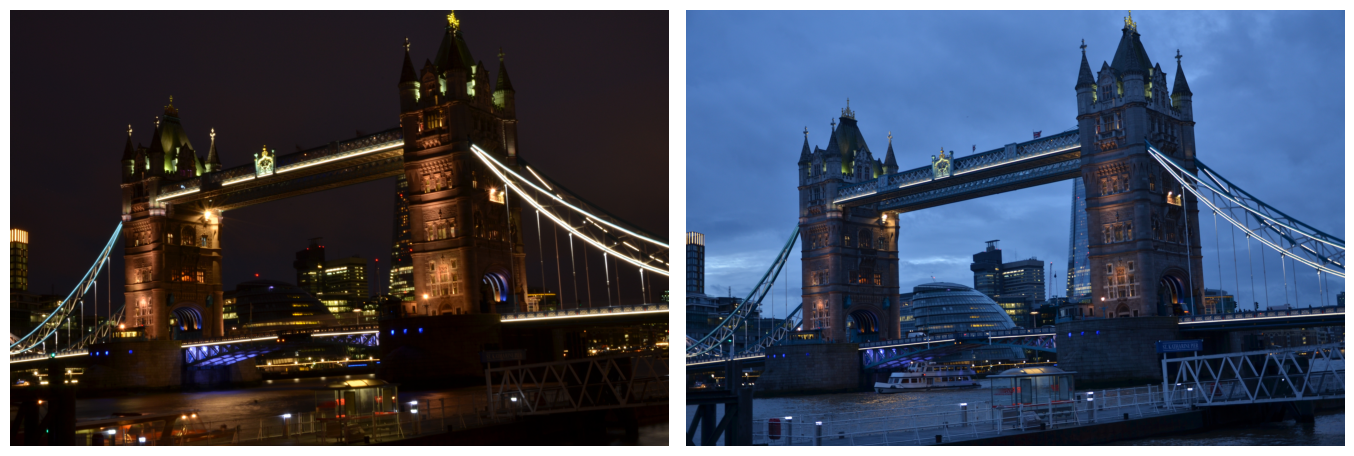

In [ ]:
images = Path("./data/hpatches-sequences-release/i_londonbridge")  # different (i)llumination
image_i_0 = load_image(images / '1.ppm')
image_i_1 = load_image(images / '5.ppm')
plot_images([image_i_0, image_i_1])

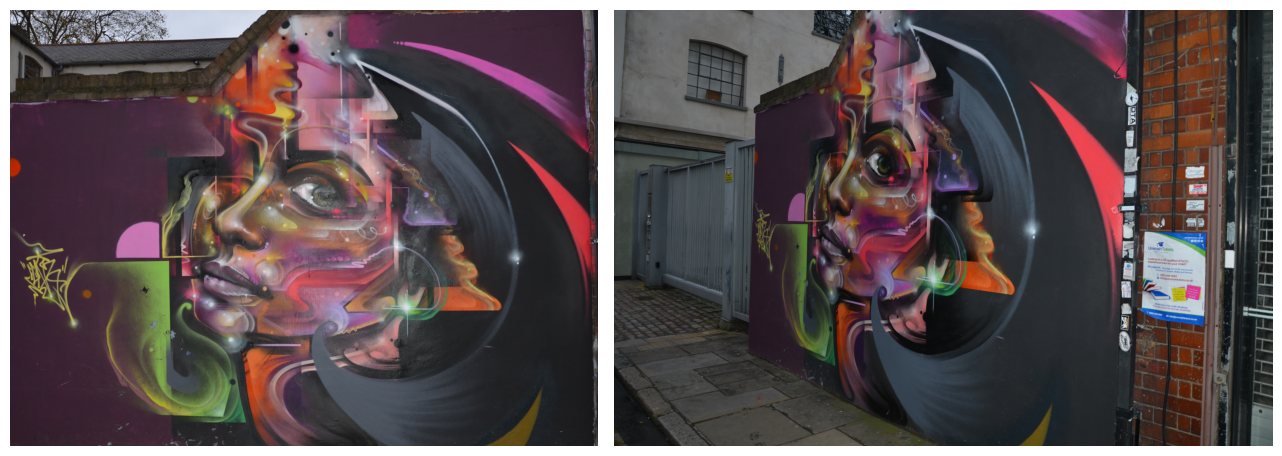

In [34]:
images = Path("./data/hpatches-sequences-release/v_woman")  # different (v)iewpoint
image_v_0 = load_image(images / '1.ppm')
image_v_1 = load_image(images / '6.ppm')
plot_images([image_v_0, image_v_1])

### Experiment

In [48]:
ds = HPatchesDataset(resize=480)  # load the dataset
print(f"Total number of image pairs: {len(ds)}")

extractor = SuperPoint(max_num_keypoints=1024).eval().to(device)  # load the extractor 
matcher = LightGlue(features="superpoint").eval().to(device)  # load the matcher

Total number of image pairs: 580


In [45]:
def cartesian_to_homogeneous(points: torch.Tensor) -> torch.Tensor:
    ones = torch.ones((points.shape[0], 1), device=points.device, dtype=points.dtype)
    return torch.cat([points, ones], dim=1)


def homogeneous_to_cartesian(points_h: torch.Tensor, eps: float = 0.0) -> torch.Tensor:
    return points_h[..., :-1] / (points_h[..., -1:] + eps)


def project_points(points: torch.Tensor, T: torch.Tensor) -> torch.Tensor:
    points_h = cartesian_to_homogeneous(points)
    proj = (T @ points_h.T).T
    return homogeneous_to_cartesian(proj)


def compute_reprojection_error(
    kpts0: torch.Tensor, kpts1: torch.Tensor, H_gt: np.ndarray, thr: float = 3.0
) -> Dict[str, float]:
    H_gt = torch.from_numpy(H_gt).to(kpts0.device)
    kpts0_proj = project_points(kpts0, H_gt)

    reproj_errors = torch.norm(kpts0_proj - kpts1, dim=1)
    inliers = reproj_errors < thr

    num_matches = len(kpts0)
    correct_matches = inliers.sum().item()

    # TO COMPLETE
    return {"correct_matches": correct_matches, "total_matches": num_matches}


def compute_mean_corner_distance(
    H_est: torch.Tensor, H_gt: torch.Tensor, W: int, H: int
) -> float:
    corners = torch.tensor(
        [[0, 0], [W - 1, 0], [W - 1, H - 1], [0, H - 1]],
        dtype=torch.float32,
        device=H_est.device,
    )

    corners_gt = project_points(corners, H_gt)
    corners_est = project_points(corners, H_est)

    dist = torch.norm(corners_gt - corners_est, dim=1)
    # TO COMPLETE
    return dist.mean().item()


def evaluate_pair(ex: Dict[str, Any], visualize: bool = False) -> None:
    image0 = ex["image0"].to(device)
    image1 = ex["image1"].to(device)
    H_gt = ex["H_0to1"]

    # Extract keypoints and perform matching
    feats0, feats1, matches01 = match_pair(extractor, matcher, image0, image1)
    matches = matches01["matches"]  # indices with shape (K,2)

    # Select only matched keypoints
    kpts0 = feats0["keypoints"][matches[:, 0]]  # coordinates in image0 with shape (K,2)
    kpts1 = feats1["keypoints"][matches[:, 1]]  # coordinates in image1 with shape (K,2)

    # Matches visualization
    if visualize:
        visualize_matches(image0, image1, kpts0, kpts1, matches01["stop"])

    H_est, inliers = cv.findHomography(
        kpts0.cpu().numpy(), kpts1.cpu().numpy(), cv.RANSAC, ransacReprojThreshold=3.0
    )

    return compute_reprojection_error(kpts0, kpts1, H_gt)


def visualize_matches(
    image0: torch.Tensor, image1: torch.Tensor, points0: torch.Tensor, points1: torch.Tensor, stop_layer: int
) -> None:
    axes = plot_images([image0, image1])
    plot_matches(points0, points1, color="lime", lw=0.2)
    add_text(0, f'Stop after {stop_layer} layers', fs=20)
    plt.show()

In [135]:
# def evaluate_pair(ex: Dict[str, Any]) -> None:
#     image0 = ex["image0"].to(device)
#     image1 = ex["image1"].to(device)
#     H_gt = ex["H_0to1"]

#     # Extract keypoints and perform matching
#     feats0, feats1, matches01 = match_pair(extractor, matcher, image0, image1)
#     matches = matches01["matches"]

#     # Select only matched keypoints
#     kpts0 = feats0["keypoints"][matches[:, 0]]
#     kpts1 = feats1["keypoints"][matches[:, 1]]

#     H_est, inliers = cv.findHomography(
#         kpts0.cpu().numpy(), kpts1.cpu().numpy(), cv.RANSAC, ransacReprojThreshold=3.0
#     )

#     return compute_reprojection_error(kpts0, kpts1, H_gt)

In [154]:
all_correct_matches, all_total_matches = 0, 0

for i in tqdm(range(len(ds))):
    metrics = evaluate_pair(ds[i])
    all_correct_matches += metrics["correct_matches"]
    all_total_matches += metrics["total_matches"]

precision = all_correct_matches / all_total_matches
print(f"Precision: {precision}")

  0%|          | 0/580 [00:00<?, ?it/s]

100%|██████████| 580/580 [00:43<00:00, 13.24it/s]

Precision: 0.910783565735435


### Presenting the results

In [46]:
def find_pair(scene: str, seq_idx: Literal[2,3,4,5,6]) -> Optional[int]:
    if not (2 <= seq_idx <= 6):
        raise ValueError("seq_idx must be between 2 and 6")

    for i in tqdm(range(len(ds))):
        ex = ds[i]
        if ex["scene"] == scene and ex["seq_idx"] == seq_idx:
            return i
    return None

#### Image pair with different illumination:

  0%|          | 0/580 [00:00<?, ?it/s]

 25%|██▍       | 143/580 [00:08<00:24, 17.83it/s]


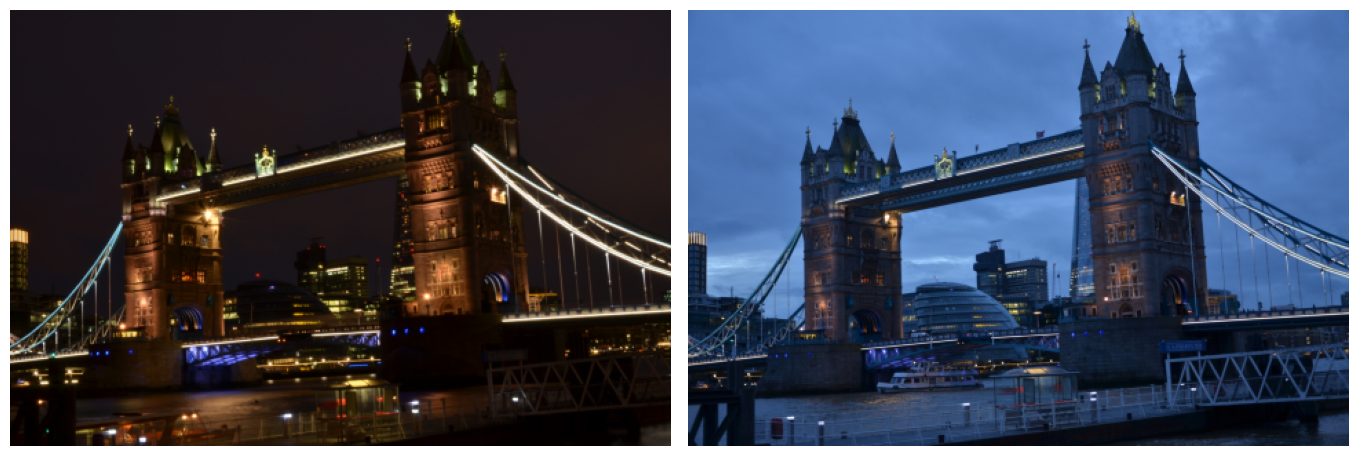

In [ ]:
pair_idx_i = find_pair("i_londonbridge", 5)
ex_i = ds[pair_idx_i]
plot_images([ex_i["image0"], ex_i["image1"]])

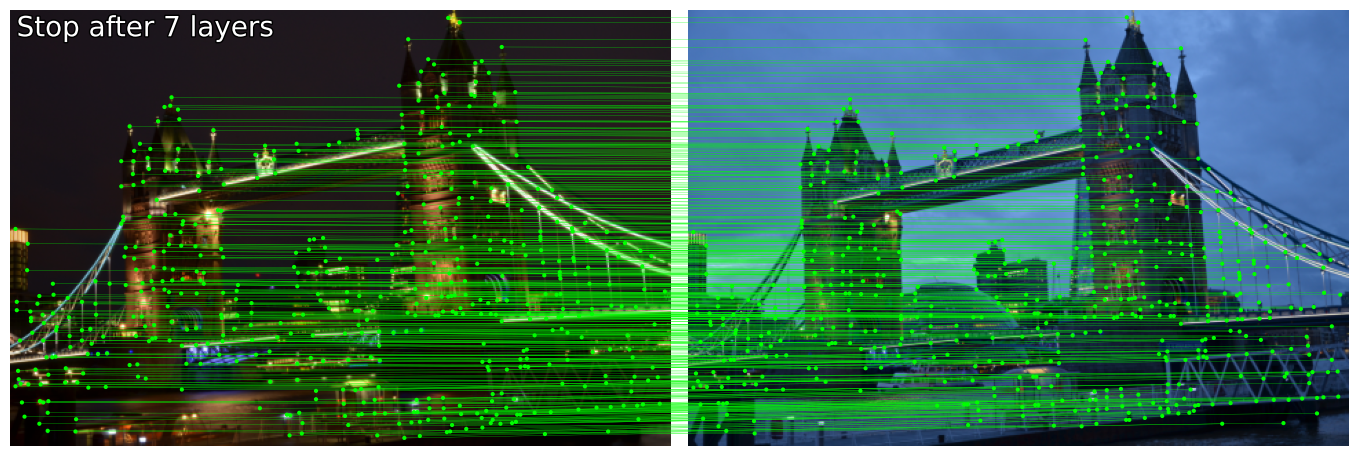

In [158]:
metrics = evaluate_pair(ex_i, True)

#### Image pair with different viewpoint:

  0%|          | 0/580 [00:00<?, ?it/s]

 96%|█████████▋| 559/580 [00:35<00:01, 15.66it/s]


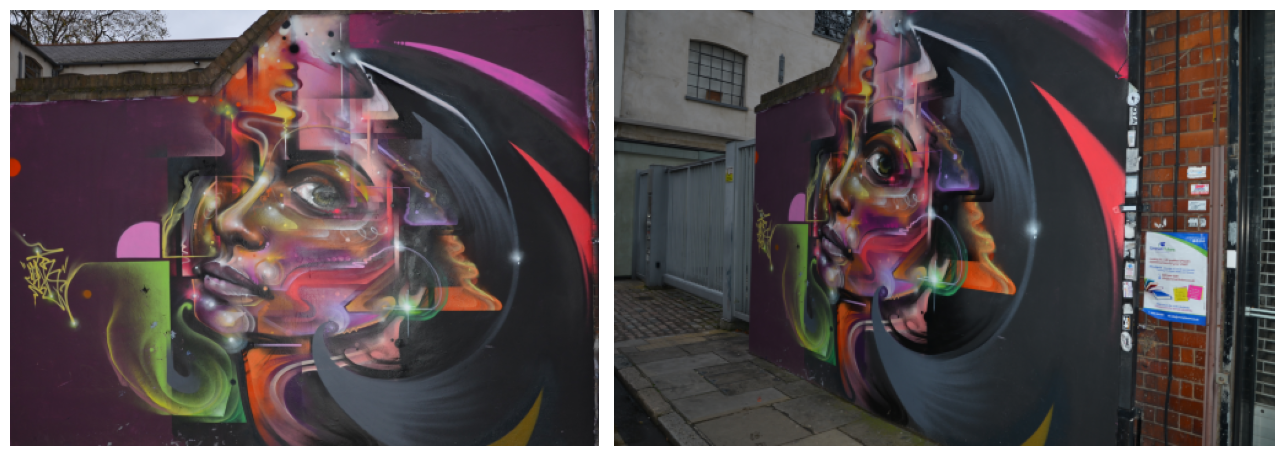

In [47]:
pair_idx_v = find_pair("v_woman", 6)
ex_v = ds[pair_idx_v]
plot_images([ex_v["image0"], ex_v["image1"]])

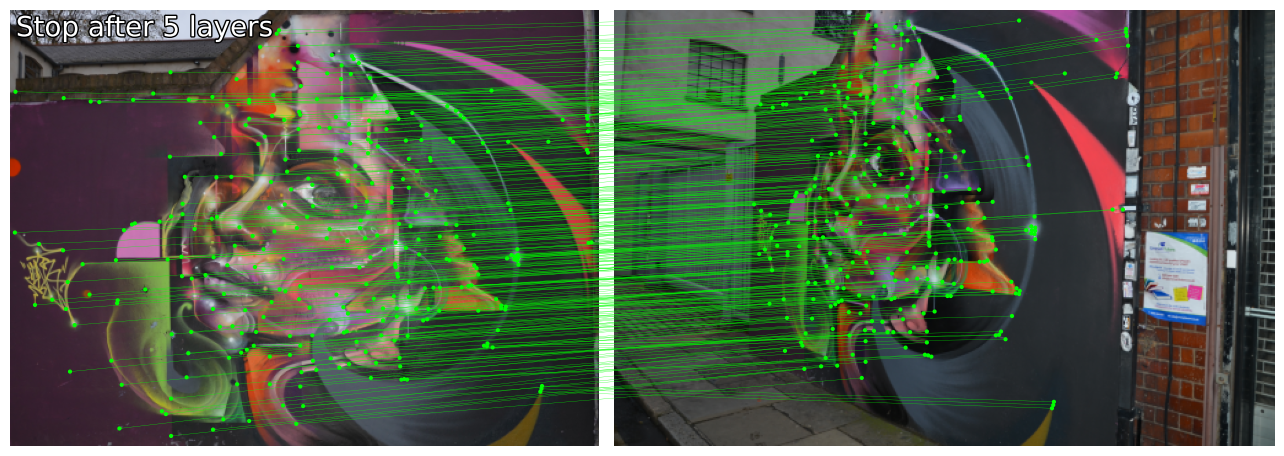

In [49]:
metrics = evaluate_pair(ex_v, True)